In [70]:
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from random import randint

In [143]:
def build_tfidf(guidelines: list[str], pca_component=100):
    # Preprocess all documents (prior to building the vocabulary)
    corpus = []

    print(' - Proprocess and extract the corpus')
    for guideline in tqdm(guidelines):
        text = guideline["text"]

        # Replacing unconventional punctuation with spaces
        text = re.sub(r'[\(\)\[\]\,\-\;\.\!\?”“\"\']', ' ', text)
        text = re.sub(r'[\*+\_\#]+', ' ', text)
        text = re.sub(r'\s+', ' ', text)

        # Stemming is done by sklearn
        corpus.append(text)
    
    # Build the vocabulary matrix
    print(' - Vectorize the corpus')
    vectorizer = CountVectorizer(min_df=0.01, max_df=0.9, token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b") # Must be less that 80%
    counts = vectorizer.fit_transform(corpus).toarray()

    # Learn the IDF matrix
    print(' - Learn the IDF for each terms')
    transformer = TfidfTransformer(use_idf=False)
    transformer.fit(counts)

    # Build the TF-IDF matrix for each sample of the corpus
    print(' - Build the TF-IDF dense matrix')
    tfidf = transformer.transform(counts + 1).toarray() # Smoothing of the count

    # Running PCA on tf-idf matrix to select the important words
    pca = PCA(n_components=pca_component)
    pca.fit(tfidf)

    # Finally transform the tfidf matrix into a smaller collection
    compact_tfidf = pca.transform(tfidf)
    return compact_tfidf, pca, transformer, vectorizer

In [144]:
GUIDELINE_PATH = join('..', 'Guidelines', 'meditron-guidelines', 'processed')

In [145]:
# Retrieve all guidelines
print(' - Retrieving guidelines')
guidelines = []
for file in listdir(GUIDELINE_PATH):
    path = join(GUIDELINE_PATH, file)

    if path.endswith('.jsonl'):
        with open(path, 'r') as f:
            guidelines += [x for x in list(map(json.loads, f.readlines())) if 'title' in x]
# guidelines = guidelines[:5000]

 - Retrieving guidelines


In [146]:
# Preprocess all documents (prior to building the vocabulary)
corpus = []

print(' - Proprocess and extract the corpus')
for guideline in tqdm(guidelines):
    text = guideline["text"]

    # Replacing unconventional punctuation with spaces
    text = re.sub(r'[\(\)\[\]\,\-\;\.\!\?”“\"\']', ' ', text)
    text = re.sub(r'[\*+\_\#]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Stemming is done by sklearn
    corpus.append(text)

 - Proprocess and extract the corpus


100%|██████████| 42336/42336 [00:19<00:00, 2183.83it/s]


In [23]:
# Build the vocabulary matrix
print(' - Vectorize the corpus')
vectorizer = CountVectorizer(min_df=0.01, max_df=0.9, token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b") # Must be less that 80%
counts = vectorizer.fit_transform(corpus).toarray()
print(counts.shape)

 - Vectorize the corpus
(42336, 5181)


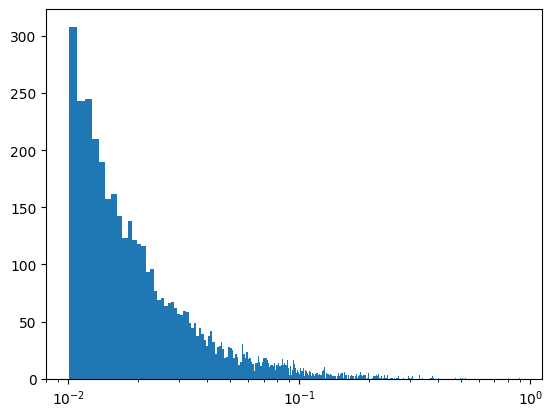

In [24]:
plt.hist(np.mean(counts >= 1, axis=0), bins=1000)
plt.xscale('log')
plt.show()

In [163]:
# Preprocess all texture (prior to building the vocabulary)
compact_idf, pca, transformer, vectorizer = build_tfidf(guidelines, pca_component=30)

 - Proprocess and extract the corpus


100%|██████████| 42336/42336 [00:18<00:00, 2245.29it/s]


 - Vectorize the corpus
 - Learn the IDF for each terms
 - Build the TF-IDF dense matrix


In [148]:
# Transform pca invert
X = np.eye(compact_idf.shape[1])
Y = pca.inverse_transform(X)

In [208]:
def distance(d1, d2):
    a = np.linalg.norm(compact_idf[d1, :])
    b = np.linalg.norm(compact_idf[d2, :])
    return np.arccos(np.dot(a, b))

def distance2(d1, d2):
    a = compact_idf[d1, :]
    b = compact_idf[d2, :]
    return np.sum((a - b)**2)


N1 = randint(0, compact_idf.shape[0] - 1)
bN2 = None
bScore = 0
N = 0

for i in range(10000):
    N2 = randint(0, compact_idf.shape[0] - 1)
    if N2 != N1:
        nScore = distance2(N1, N2)
        if bN2 is None or nScore < bScore:
            bScore = nScore
            bN2 = N2
            N += 1

print('N1: {}'.format(guidelines[N1]['title']))
print('N2: {}'.format(guidelines[bN2]['title']))
print('score: {}'.format(bScore))
print('#update: {}'.format(N))

N1: Icodextrin
N2: Benfotiamine
score: 0.0065913504787726155
#update: 12


In [164]:
sort = np.argsort(-np.abs(Y), axis=1)
sort = sort[:, :5]

for i in range(5):
    print('============================== FEATURE {} =============================='.format(i))
    M = sort[i, :]
    yy = Y[i, M]
    names = vectorizer.get_feature_names_out()[M]
    print('\n'.join('{:<30}: {}'.format(name, p) for name, p in zip(names, yy)))

    MID = np.argsort(-np.abs(compact_idf[:, i]))[:5]
    print('; '.join([guidelines[x]['title'] for x in MID]))

============================== FEATURE 0 ==============================
with                          : 0.33440280285993423
for                           : 0.32210835287563516
or                            : 0.3114318021972206
be                            : 0.22021235097119232
that                          : 0.20263940178902426
2016 Infectious Diseases Society of America (IDSA) Clinical Practice Guideline for the Treatment of Coccidioidomycosis; Diagnosis and Treatment of Leishmaniasis: Clinical Practice Guidelines by the Infectious Diseases Society of America (IDSA) and the American Society of Tropical Medicine and Hygiene (ASTMH); Clinical Practice Guidelines for Clostridium difficile Infection in Adults and Children: 2017 Update by the Infectious Diseases Society of America (IDSA) and Society for Healthcare Epidemiology of America (SHEA); Practice Guidelines for the Diagnosis and Management of Aspergillosis: 2016 Update by the Infectious Diseases Society of America; Fluoxetine
====

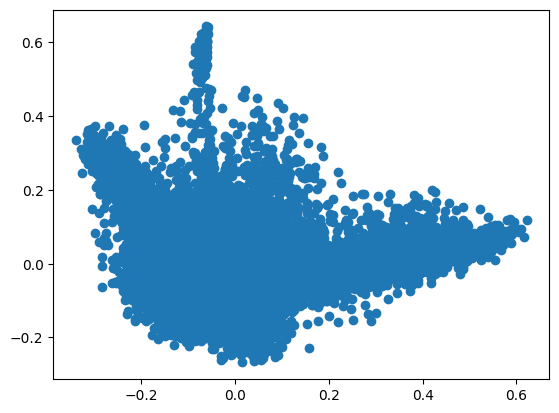

In [209]:
A, B = compact_idf.T[2, :], compact_idf.T[3, :]
plt.scatter(A, B)